# Saint James Cancellations Analysis

This notebook analyzes Saint James Hostel's cancellations bookings from January to June 2023 to assess their financial impact and determine whether anything can be inferred about which types of customers tend to cancel their booking.

Key takeaways include:

    1) cancellations increased into the summer months
    2) cancellations in June were valued at over £70,000
    3) multi-night, guest and room bookings are more likely to cancel

In [1]:
# imports key libraries
import pandas as pd
import numpy as np

# creates a local link to the archive spreadsheet object
archive = 'C:/Users/HUAWEI/Desktop/Projects/SJ-Cancellations-Analysis/Data/Archive.xlsx'

# creats a list of archive sheet names
check_out_sheets = ['CANCELLATIONS JAN ', 'CANCELLATIONS FEB', 'CANCELLATIONS MARCH', 'CANCELLATION APR', 'CANCELLATION MAY', 'CANCELLATION JUN']

# reads-in a list of archive check-out sheets
check_out_dfs = []
for i in range(len(check_out_sheets)):
    check_out_dfs.append(pd.read_excel(archive, check_out_sheets[i]))
    
for i in range(len(check_out_dfs)):
    check_out_dfs[i] = check_out_dfs[i].iloc[:,0:15]
    
# creates a column names object
check_outs_col_names = ['Check-in', 'Check-out', 'Nights', 'Guests', 'room', 'room_1', 'name', 'Price', 'paid', 'Booking Type', 'KD cash', 'KD card', 'comment', 'payment status', 'Checked status']

# changes the column names for each sheet
for i in range(len(check_out_dfs)):
    check_out_dfs[i].columns = check_outs_col_names
    
# joins each check-out sheet together to create a single check-out dataframe
check_out_df = pd.concat(check_out_dfs)

# saves the check-out dataframe so that changes can be made on the spreadsheet in preparation for data cleaning
check_out_df.to_excel('Data/check_out_df.xlsx') 

# prints the first 6 rows of the new check-out dataframe
check_out_df

,Check-in,Check-out,Nights,Guests,room,room_1,name,Price,paid,Booking Type,KD cash,KD card,comment,payment status,Checked status
0,2023-01-19 00:00:00,2023-01-23 00:00:00,4.0,2,37,37,Joana Braz Martins,410.4,NaN,booking hcn,NaN,NaN,card to be validated by booking.com,charge on arrival,OM CHECKED
1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-02 00:00:00,2023-01-09 00:00:00,7.0,1,3,3F,Alexandra Gasca,146.88,NaN,HW,NaN,NaN,preauth declined (02/01) - guest emailed us to...,charge on arrival,OM CHECKED
3,2023-01-21 00:00:00,2023-01-24 00:00:00,3.0,3,6,6,Ana Garcia Marin,234.9,NaN,booking hcn,NaN,NaN,card to be validated by booking.com,charge on arrival,OM CHECKED
4,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,2023-07-21 00:00:00,2023-07-30 00:00:00,9.0,1.0,2,2B,MOHAMED MOHAMED ISMAIL,532.1,NaN,expedia vc,NaN,NaN,"booked a female dorm, double check that's corr...",charge vc on day,NaN
163,2024-04-20 00:00:00,2024-04-21 00:00:00,1.0,1.0,33,33A,Rosemary Hughes,60,NaN,booking vcd,NaN,NaN,NaN,charge vc on day,NaN
164,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1) Data cleaning

### Locate non-blank rows

In [2]:
# imports key libraries
import pandas as pd
import numpy as np

# reads in the combined check-out dataframe
check_out_df = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/SJ-Cancellations-Analysis/Data/check_out_df.xlsx')

# creates an index object denoting which rows are non-NA and therefore valid rows
col = check_out_df['Check-in']
index = []
for i in range(len(col)):
    try:
        col[i].year
        index.append(i)
    except:
        pass

# resets the check-out dataframe to non-NA rows
check_out_df = check_out_df.iloc[index,:].reset_index(drop=True)

# creates a new dataframe including only non-NA rows for the first 3 columns
clean_check_out_df = pd.DataFrame()
check_out_df = check_out_df[pd.isna(check_out_df.iloc[:,0:1]).sum(axis=1)==0].reset_index(drop=True)

### Separate check-in dates

In [3]:
# imports necessary libraries
import datetime as dt
import statistics as stats

# makes sure no NA values are passed through into the clean dataset
def get_col(df, col_name, dot_method=None):
    col = df[col_name]
    values = []
    for i in range(len(col)):
        try:
            if dot_method != None:
                values.append(eval('df[col_name][i]' + dot_method))
            else:
                values.append(df[col_name][i])
        except:
            pass
    return [i for i in values if pd.isna(i) == False]

# creates seperate columns for the check-in year, month and day
clean_check_out_df['In-Year'] = get_col(check_out_df, 'Check-in', '.year')
clean_check_out_df['In-Month'] = get_col(check_out_df, 'Check-in', '.month')
clean_check_out_df['In-Day'] = get_col(check_out_df, 'Check-in', '.day')

### Separate check-out dates

In [4]:
# creates an NA free nights column to be added to the check-in date to calcuate check-out
nights = get_col(check_out_df, 'Nights')
check_in = get_col(check_out_df, 'Check-in')

# adds nights to check-in to determine check-out
check_out = []
for i in range(len(nights)):
    check_out.append(check_in[i] + dt.timedelta(days = nights[i]))
    
# creates a new dataframe object containing check-outs data
check_out = pd.DataFrame({'check_out': check_out})

# creates 3 seperate columns for the check-outs year, month and day
clean_check_out_df['Out-Year'] = get_col(check_out, 'check_out', '.year')
clean_check_out_df['Out-Month'] = get_col(check_out, 'check_out', '.month')
clean_check_out_df['Out-Day'] = get_col(check_out, 'check_out', '.day')

### View NAs

In [5]:
# creates a cols object for looping
cols = ['Nights', 'Guests', 'room', 'Price', 'Booking Type', 'KD cash', 'KD card', 'payment status', 'Checked status']

# creates a length object for calculating NA percentages
total = len(check_out_df)

# calculates total NAs and NA percentages
NAs = []
percent = []
for i in range(len(cols)):
    NAs.append(sum(check_out_df[cols[i]].isna()))
    percent.append((round(sum(check_out_df[cols[i]].isna()) / total, 3))*100)

# displays NA counts and percentages as a dataframe
pd.DataFrame({'Column': cols, 'NA Count': NAs, 'Percent (%)': percent})

,Column,NA Count,Percent (%)
0,Nights,0,0.0
1,Guests,3,0.4
2,room,9,1.3
3,Price,3,0.4
4,Booking Type,2,0.3
5,KD cash,696,99.0
6,KD card,660,93.9
7,payment status,10,1.4
8,Checked status,275,39.1


### Fill NAs

In [6]:
# assigns the nights object as the nights column
clean_check_out_df['Nights'] = nights

# fills missing guests values with the median
clean_check_out_df['Guests'] = check_out_df['Guests'].fillna(1)

# fills missing room values with room 21
clean_check_out_df['Room'] = check_out_df['room'].fillna(21)

# fills missing price values in with the median price
clean_check_out_df['Price'] = check_out_df['Price'].fillna(25)

# fills missing booking type values with booking vc
clean_check_out_df['Booking Type'] = check_out_df['Booking Type'].str.lower().fillna('Booking VC')

# fills missing kd cash and card values with 0 
clean_check_out_df['KD Cash'] = check_out_df['KD cash'].fillna(0)
clean_check_out_df['KD Card'] = check_out_df['KD card'].fillna(0)

# fills missing payment status values with 'none'
clean_check_out_df['Payment Status'] = check_out_df['payment status'].str.lower().fillna('none')

# creates a binary column where an NA value is assumed to mean the booking was not checked
clean_check_out_df['Booking Checked'] = [1 if i is not True else 0 for i in check_out_df['Checked status'].isna()]

## 2) Transformations

### Transform standard columns

In [7]:
# bookings each month
by_months = clean_check_out_df['In-Month'].value_counts().sort_index().iloc[0:6]

# bookings by number of nights
by_nights = clean_check_out_df['Nights'].value_counts().sort_index().iloc[0:10]
total_by_nights = [2392,  914,  576,  329,  182,   79,  248,   32,    7,   16]
adjusted_by_nights = (by_nights / total_by_nights)*100

# bookings by number of guests
clean_check_out_df.loc[clean_check_out_df['Guests']=='3 (1 adult, 2 kids)', 'Guests'] = 3
clean_check_out_df.loc[clean_check_out_df['Guests']=='5 (2 adults, 3 kids)', 'Guests'] = 5
clean_check_out_df.loc[clean_check_out_df['Guests']=='2 (1 adult, 1 kid)', 'Guests'] = 2

by_guests = clean_check_out_df['Guests'].value_counts().sort_index().iloc[0:4]
total_by_guests = [4033,  575,  185,   34]
adjusted_by_guests = (by_guests / total_by_guests)*100

# bookings by individual rooms
by_room = clean_check_out_df['Room'].astype(str).value_counts().sort_index()

# months by total price in thousands
clean_check_out_df.loc[clean_check_out_df['Price']=='551.86 GBP', 'Price'] = 551.86
clean_check_out_df.loc[clean_check_out_df['Price']=='£-   ', 'Price'] = 50
clean_check_out_df['Price'] = pd.to_numeric(clean_check_out_df['Price'])
by_price = round(clean_check_out_df.groupby('In-Month').sum()['Price'].iloc[0:7:] / 1000, 1).reset_index(drop=True)

### Transform % of bookings

In [8]:
# lists total bookings each month
total_bookings = [495, 505, 625, 649, 763, 876]

# divides no shows by total bookings to get no shows as a percent of bookings 
by_percent_bookings = (by_months / total_bookings) * 100

### Transform room type

In [9]:
# filters out problematic values
problems = ['03/21', '1900-01-04 00:00:00', '2025-04-01 00:00:00']
index = [True if i not in problems else False for i in by_room.index]
by_room = by_room[index]

# creates lists of rooms for each room type
private = ['A', 'B', 'C', '30', '31', '37']
eight_bed = ['3', '4', '21', '24']
female = ['2', '5', '23']
six_bed = ['36', '32']
four_bed = ['33', '34', '35']
triple = ['1', '6', '20', '25']

# loops through the by room summary and assigns a room type to the room_type object
room_type = []
for  i in range(len(by_room)):
    if by_room.index[i] in private:
        room_type.append('Private')
    elif by_room.index[i] in eight_bed:
        room_type.append('8 bed')
    elif by_room.index[i] in female:
        room_type.append('Female')
    elif by_room.index[i] in six_bed:
        room_type.append('6 bed')
    elif by_room.index[i] in four_bed:
        room_type.append('4 bed')
    elif by_room.index[i] in triple:
        room_type.append('Triple')
    else:
        room_type.append('Multiple')

# creates a dataframe of rooms, counts and types
room_df = pd.DataFrame({'Room': by_room.index, 'Count': by_room, 'Type': room_type}).reset_index(drop=True)

# sorts the data by value count / changed to index
by_room = room_df.Count.sort_values(ascending=False)
by_room.index = room_df.Room

# sums the data after grouping by room type and reverses the order to be descending
by_room_type = room_df[['Count', 'Type']].groupby('Type').sum().iloc[:,0].sort_values(ascending=True)
by_room_type = by_room_type[::-1]
by_room_type = by_room_type.sort_index()[0:6]
total_by_room_type = [498,  670, 1658, 1250,   44,  507]
adjusted_by_room_type = (by_room_type[0:6].sort_index() / total_by_room_type) * 100

### Transform booking type

In [10]:
# removes extra whitespace
clean_check_out_df['Booking Type'] = [x.strip() for x in clean_check_out_df['Booking Type']]

# converts mispelled booking vcs 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'booking', 'Booking Type'] = 'booking vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'bookin vc', 'Booking Type'] = 'booking vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'bookingvcd', 'Booking Type'] = 'booking vcd'

# converts mispelled expedia vcns 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'expediavcn', 'Booking Type'] = 'expedia vcn'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'expediavcn', 'Booking Type'] = 'expedia vcn'

# converts group booking to group for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'group booking', 'Booking Type'] = 'group'

# converts trip.com entries into trip for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'trip', 'Booking Type'] = 'trip vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'trip.com', 'Booking Type'] = 'trip vc'

# converts mispelled walk-ins 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk ', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'wak-in', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk in', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walkin', 'Booking Type'] = 'walk-in'

# converts weekly rate to weekly for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'weekly rate', 'Booking Type'] = 'weekly'

# converts to lower, counts values and sorts in descending order
by_booking_type = clean_check_out_df['Booking Type'].str.lower().value_counts().sort_values(ascending=False)

### Transform booking provider

In [11]:
# assigns different booking types to a booking_provider object
booking_provider = []
for i in range(len(clean_check_out_df)):
    if 'ooking' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('booking')
    elif 'expedia' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('expedia')
    elif 'trip' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('trip')
    else:
        booking_provider.append(clean_check_out_df['Booking Type'][i])

# creates a new booking provider column in the clean dataframe
clean_check_out_df['Booking provider'] = booking_provider

# counts different booking provider types and converts the index to title
by_booking_provider = clean_check_out_df['Booking provider'].value_counts().iloc[0:6]
by_booking_provider.index = by_booking_provider.index.str.title()

#
by_booking_provider = by_booking_provider.sort_index().iloc[0:4]
total_by_booking_provider = [139, 2723,  230,  658]
adjusted_by_booking_provider = (by_booking_provider.sort_index() / total_by_booking_provider) * 100

### Transform paid

In [12]:
# lists all the mispellings of paid
paid_mispellings = ['paind', 'paid  ', 'paid by paynow', 'paud ', 'piad', 'paid paynow',
                    'paid with paynow', 'oaid', 'paid  paynow', 'paid   ', 
                    ' paid', 'paidl', 'paynow', 'paif', 'paid by pay now', 'paid ']

# converts all instances of paid mispellings to paid
for i in range(len(clean_check_out_df)):
    if clean_check_out_df['Payment Status'][i] in paid_mispellings:
        clean_check_out_df['Payment Status'][i] = 'paid'

#  creates two binary lists indicating paid or not paid
paid = []
not_paid = []
for i in range(len(clean_check_out_df)):
    if clean_check_out_df['Payment Status'][i] == 'paid':
        paid.append(1)
        not_paid.append(0)
    else:
        paid.append(0)
        not_paid.append(1)

# creates two new binary columns in the dataframe indicating paid and not paid
clean_check_out_df['paid'] = paid
clean_check_out_df['not paid'] = not_paid

# sums paid and not paid by month and then calculates a paid ratio
paid_months = clean_check_out_df[['In-Month', 'paid']].groupby('In-Month').sum().iloc[0:7].squeeze()
not_paid_months = clean_check_out_df[['In-Month', 'not paid']].groupby('In-Month').sum().iloc[0:7].squeeze()
by_payment_mistakes = round((not_paid_months / (paid_months+not_paid_months))*100,2)

# creates a price not paid measure
by_price = by_price.reset_index(drop=True)
by_payment_mistakes = by_payment_mistakes.reset_index(drop=True)
by_price_not_paid = by_price * (by_payment_mistakes/100)

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_14548\868415291.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_check_out_df['Payment Status'][i] = 'paid'


### Transform dates to weekdays

In [13]:
# takes in the date and gives back the day of the week
def calculate_day_of_week(year, month, day):
    try:
        # Create a datetime object for the given date
        date_obj = dt.datetime(year, month, day)
        # Get the day of the week as an integer (Monday is 0 and Sunday is 6)
        day_of_week = date_obj.weekday()
        
        return day_of_week
    except ValueError as e:
        return str(e)

# calculates the day of the week for each booking in the dataframe
weekdays = []
for i in range(len(clean_check_out_df)):
    year = clean_check_out_df['In-Year'][i]
    month = clean_check_out_df['In-Month'][i]
    day = clean_check_out_df['In-Day'][i]
    weekdays.append(calculate_day_of_week(year, month, day))
    
# creates a weekdays column
clean_check_out_df['weekday'] = weekdays

# counts weekdays and sorts the index
by_weekday = clean_check_out_df['weekday'].value_counts().sort_index()
total_by_weekday = [695, 697, 691, 696, 763, 784, 531]
adjusted_by_weekday = (by_weekday / total_by_weekday)*100

## 3) Vizualizations

### Financial overview

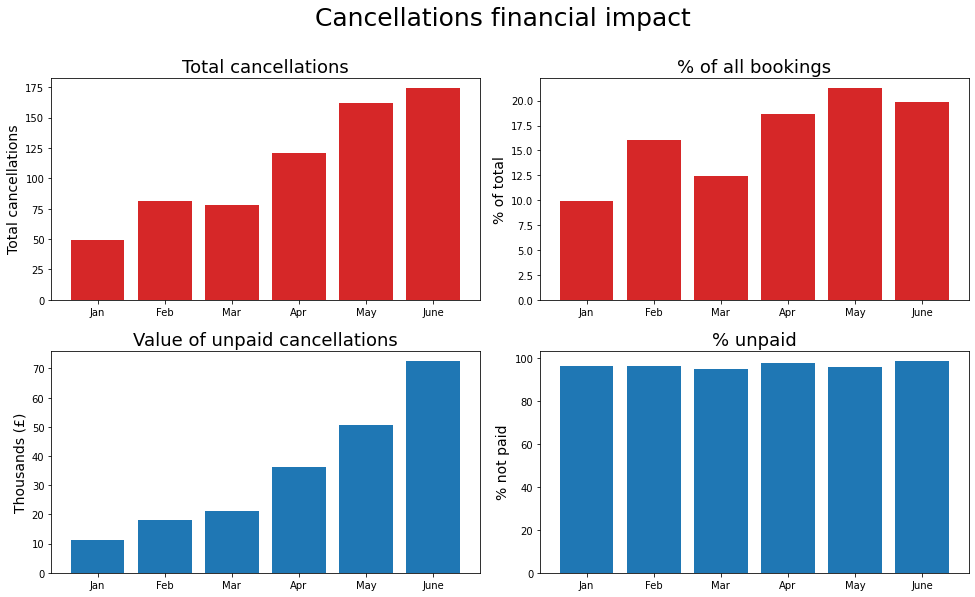

In [14]:
import matplotlib.pyplot as plt 

plots = ['by_percent_bookings', 'by_months', 'by_payment_mistakes.iloc[0:6]', 'by_price_not_paid.iloc[0:6]']

titles = ['% of all bookings', 'Total cancellations', '% unpaid', 'Value of unpaid cancellations']

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June']

days = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]

xticks = [months, months, months, months]

ylabs = ['% of total', 'Total cancellations', '% not paid', 'Thousands (£)']

colors = ['tab:red', 'tab:red', 'tab:blue', 'tab:blue']

length = len(plots)
cols = 2
rows = int(np.ceil(length / cols))

fig, ax = plt.subplots(rows, cols, figsize=(14,8));
fig.tight_layout(pad=3.0);
fig.suptitle('Cancellations financial impact', y=1.065, fontsize=25);
for i in range(rows):
    for j in range(cols):
        num = (((i+1)*cols)-j)-1
        ax[i, j].bar(eval(plots[num]).index, eval(plots[num]), color=colors[num]);
        ax[i, j].set_title(titles[num], fontsize=18);
        ax[i, j].set_xticks(eval(plots[num]).index, labels=xticks[num]);
        ax[i, j].set_ylabel(ylabs[num], fontsize=14);

### Customer type overview

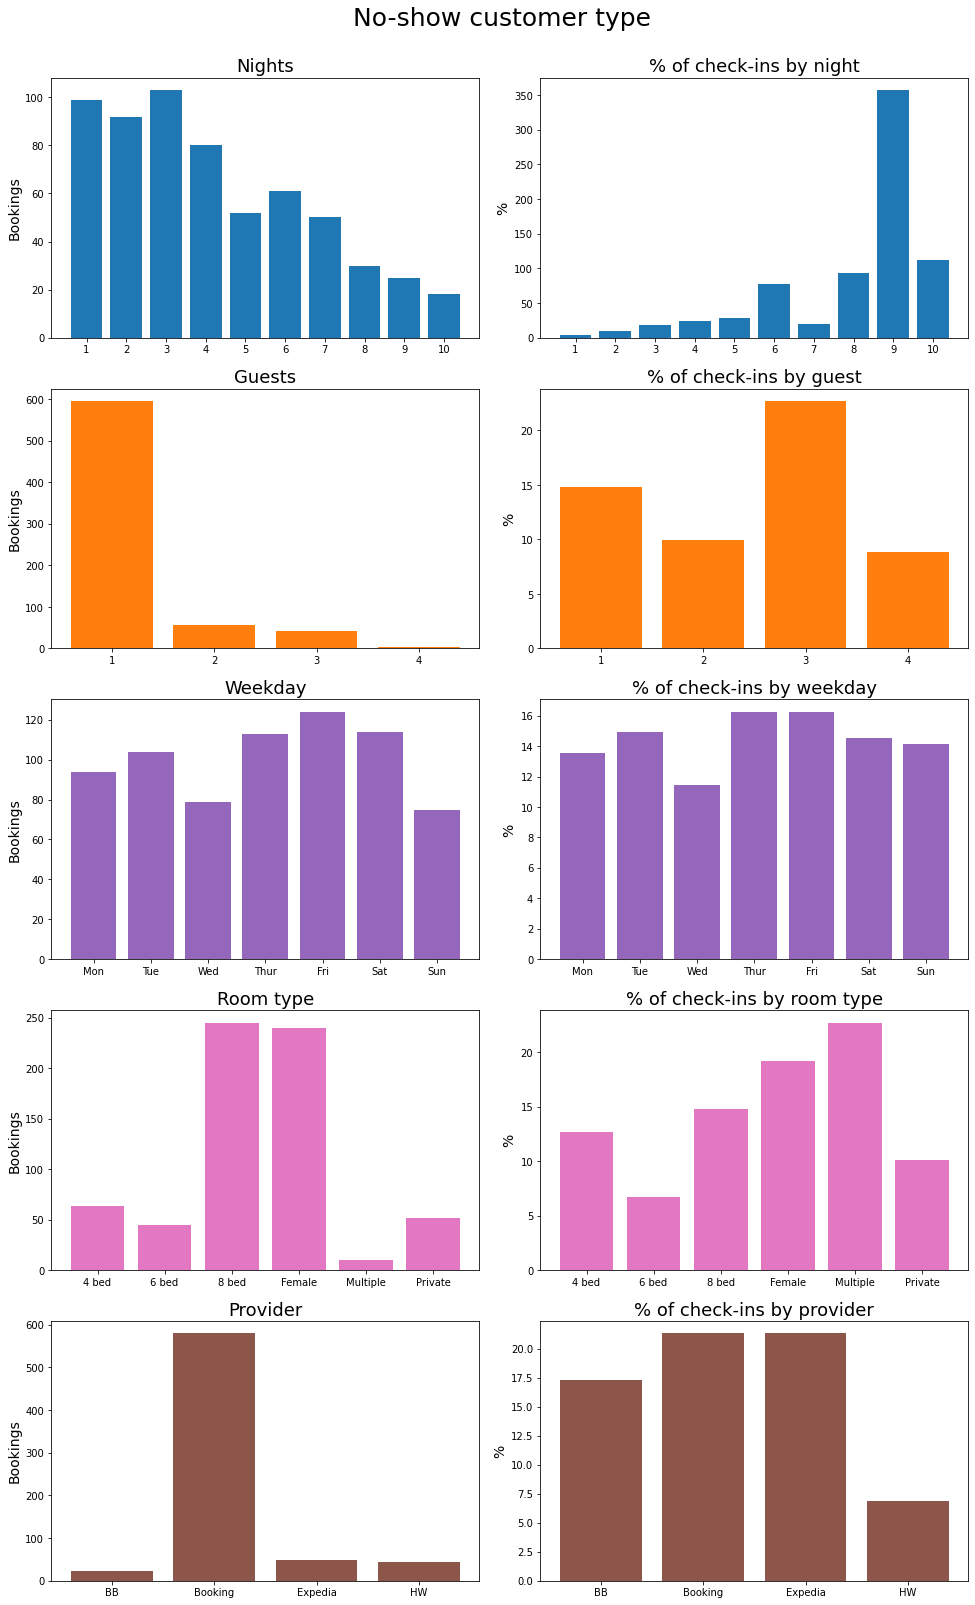

In [15]:
plots = ['adjusted_by_nights', 'by_nights', 'adjusted_by_guests', 'by_guests', 'adjusted_by_weekday', 'by_weekday',
        'adjusted_by_room_type', 'by_room_type', 'adjusted_by_booking_provider', 'by_booking_provider']

titles = ['% of check-ins by night', 'Nights', '% of check-ins by guest', 'Guests', '% of check-ins by weekday', 'Weekday',
         '% of check-ins by room type', 'Room type', '% of check-ins by provider', 'Provider']

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June']

days = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]

providers = ['BB', 'Booking', 'Expedia', 'HW']

xticks = [None, None, None, None, days, days, None, None, providers, providers]

ylabs = ['%', 'Bookings', '%', 'Bookings', '%', 'Bookings', '%', 'Bookings', '%', 'Bookings']

colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:purple', 'tab:purple', 'tab:pink', 'tab:pink',
         'tab:brown', 'tab:brown']

length = len(plots)
cols = 2
rows = int(np.ceil(length / cols))

fig, ax = plt.subplots(rows, cols, figsize=(14,22));
fig.tight_layout(pad=3.0);
fig.suptitle('No-show customer type', y=1.0235, fontsize=25);
for i in range(rows):
    for j in range(cols):
        num = (((i+1)*cols)-j)-1
        ax[i, j].bar(eval(plots[num]).index, eval(plots[num]), color=colors[num]);
        ax[i, j].set_title(titles[num], fontsize=18);
        ax[i, j].set_xticks(eval(plots[num]).index, labels=xticks[num]);
        ax[i,j].set_ylabel(ylabs[num], fontsize=14);